In [1]:
import sys
import seaborn as sns
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
data = pd.read_csv("GenreDataModified.csv")
df = pd.DataFrame(data)
df.dropna(subset=['top genre','Id'], inplace=True)
df = df.dropna()

X = df.drop(['Id','title','artist','year','top genre', 'adjusted top genre'], axis = 1)
y = df['adjusted top genre']

#Normalize each fields of input
scaler = MinMaxScaler(feature_range=(0, 1))
X_rescaled = scaler.fit_transform(X)
X_rescaled = pd.DataFrame(data = X_rescaled, columns = X.columns)
#X_rescaled = X_rescaled.fillna(0)
print(X_rescaled)

#one-hot encoding
set_of_classes = y.value_counts().index.tolist()
set_of_classes= pd.DataFrame({'adjusted top genre': set_of_classes})
y_onehot = pd.get_dummies(y)
print(y_onehot)

# Combine the normalized input features and the target variable
data0 = pd.concat([X, y], axis=1)			#data without onehot-encoding class
data1 = pd.concat([X_rescaled, y_onehot], axis=1)	#data with onehot-encoding class


          bpm      nrgy      dnce        dB      live       val       dur  \
0    0.328467  0.258065  0.346154  0.695652  0.120879  0.236559  0.125908   
1    0.313869  0.311828  0.576923  0.652174  0.120879  0.655914  0.355932   
2    0.788321  0.225806  0.371795  0.347826  0.120879  0.290323  0.324455   
3    0.430657  0.430108  0.487179  0.695652  0.142857  0.365591  0.230024   
4    0.350365  0.526882  0.679487  0.739130  0.109890  0.182796  0.302663   
..        ...       ...       ...       ...       ...       ...       ...   
433  0.131387  0.161290  0.000000  0.304348  0.087912  0.107527  0.280872   
434  0.627737  0.795699  0.448718  0.478261  0.230769  0.967742  0.118644   
435  0.773723  0.516129  0.705128  0.695652  0.197802  0.591398  0.462470   
436  0.751825  0.860215  0.589744  0.826087  0.043956  0.881720  0.225182   
437  0.313869  0.709677  0.641026  0.695652  0.131868  0.946237  0.443099   

        acous      spch       pop  
0    0.757576  0.022222  0.310345  
1  

In [2]:
"""
# Create a pair plot
sns.set(style="whitegrid")
g = sns.pairplot(data=data0, hue="Class", corner=True, palette='husl')

plt.show()
"""

'\n# Create a pair plot\nsns.set(style="whitegrid")\ng = sns.pairplot(data=data0, hue="Class", corner=True, palette=\'husl\')\n\nplt.show()\n'

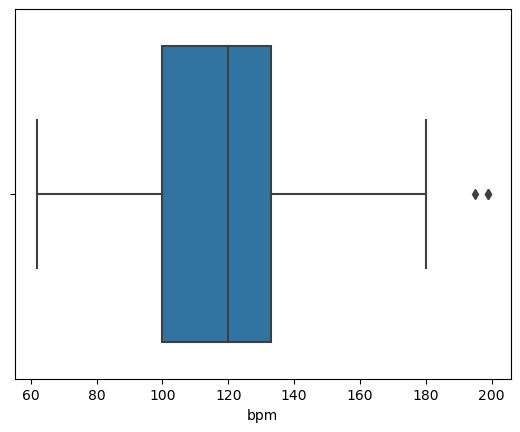

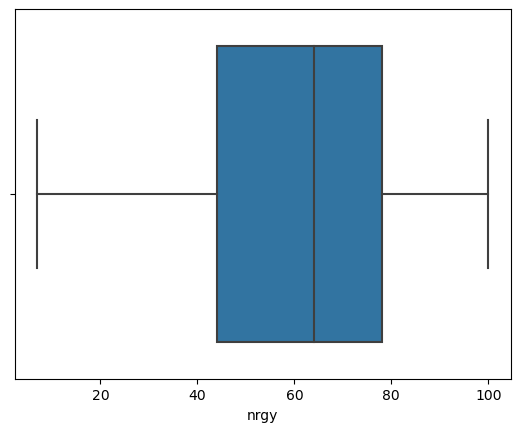

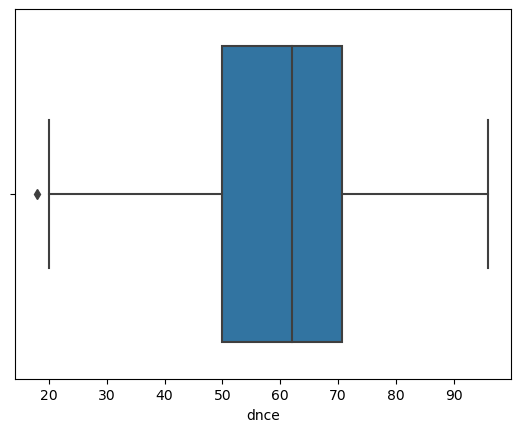

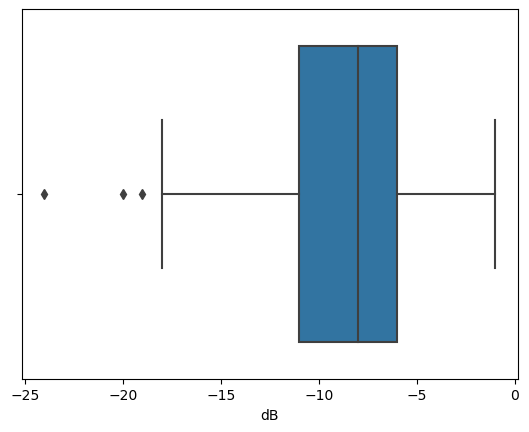

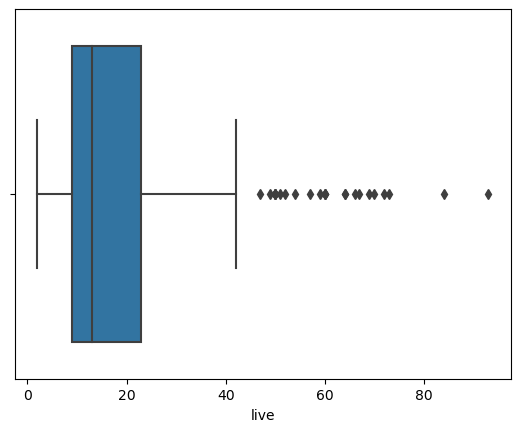

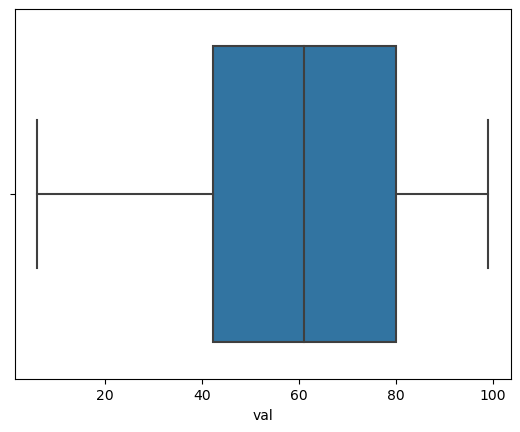

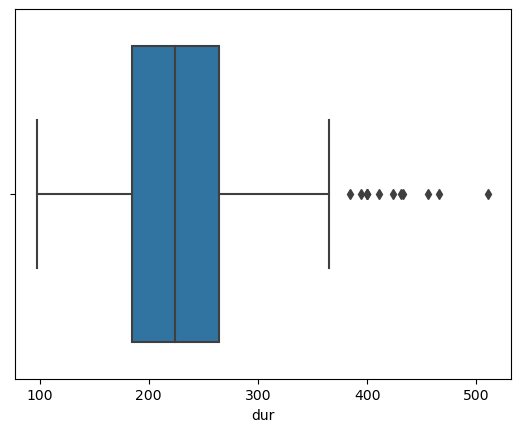

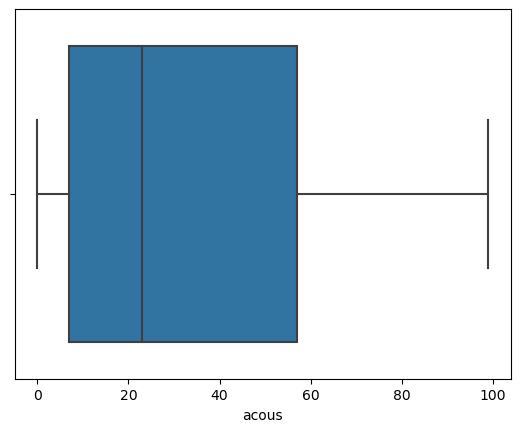

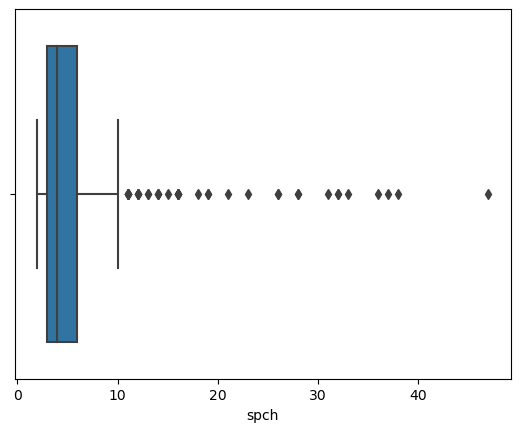

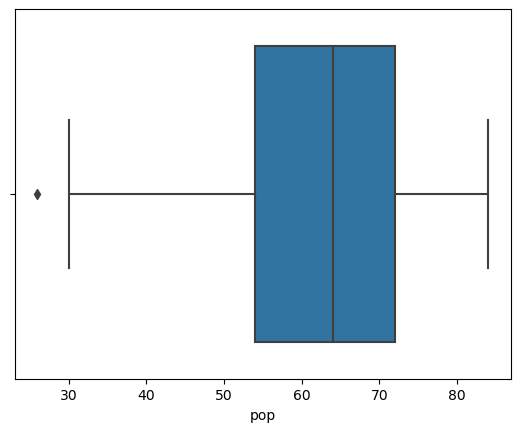

In [3]:
#Investigating possible outliers for various attributes
import seaborn as sns
sns.boxplot(x=df['bpm']) #outliers to right (not a lot)
plt.show()
sns.boxplot(x=df['nrgy']) #no outliers
plt.show()
sns.boxplot(x=df['dnce']) #outlier to left
plt.show()
sns.boxplot(x=df['dB']) # outliers to left (less)
plt.show()
sns.boxplot(x=df['live']) # many outliers (right)
plt.show()
sns.boxplot(x=df['val']) # no outliers
plt.show()
sns.boxplot(x=df['dur']) # many outliers (right)
plt.show()
sns.boxplot(x=df['acous']) # no visible outliers
plt.show()
sns.boxplot(x=df['spch']) # many outliers (right)
plt.show()
sns.boxplot(x=df['pop']) # less outliers (left)
plt.show()

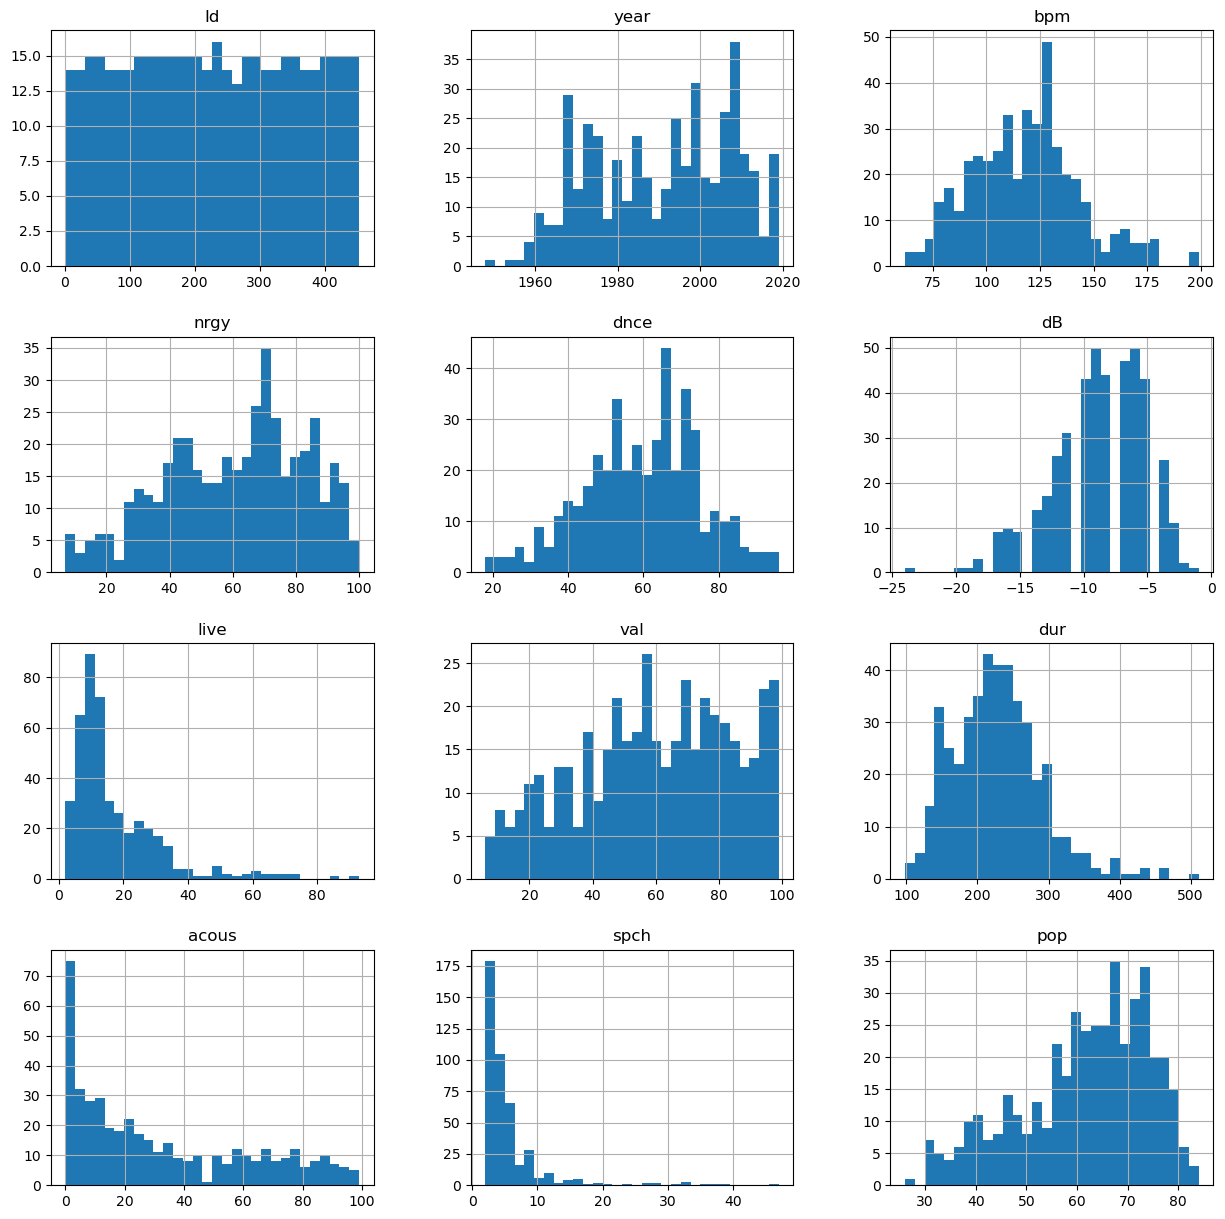

In [4]:
#Investigating skew of data
df.hist(bins=30, figsize=(15,15))
plt.show()

#right skewed for 'live', 'acous', 'spch', 'dur' attributes
#left skewed for 'nrgy', 'dB', 'val', 'pop' attributes
#roughly symmetrical for 'dnce', 'bpm' attributes
#ID and year distributions aren't being analyzed here -- categorical variables that don't affect response variable clas

# Conclusions Based on Histograms and Boxplots

Distributions of attributes dnce, bpm, nrgy, and val are roughly (ROUGHLY) symmetrical so should contribute to more accurate response variable classifications whereas the skewed nature (indicating many outliers) of other attributes could contribute to more inaccurate predictions (higher variance).

In [5]:
import warnings
from sklearn.metrics import accuracy_score,f1_score, precision_score, mean_squared_error
from sklearn.model_selection import train_test_split

from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier


models = [
	("dtree", DecisionTreeClassifier()),
	#to use svm as multi-class classification from GPT
	("svm", OneVsRestClassifier(SVC(kernel='linear', C=1))),
	("svm_poly", OneVsRestClassifier(SVC(kernel='poly', C=1))),
	("mlp",  MLPClassifier()),
	("opt_mlp",  MLPClassifier()),
	("rand_forest", RandomForestClassifier()),

 ]

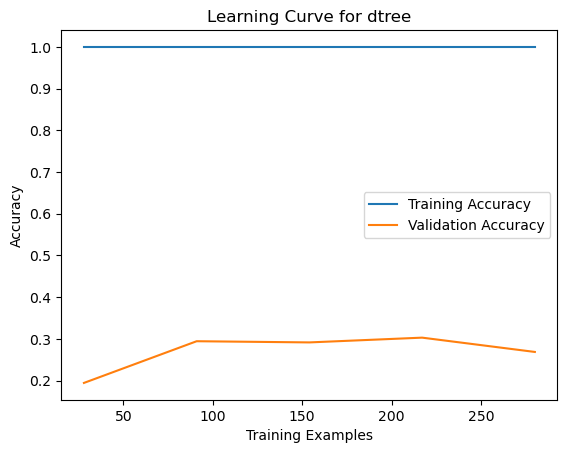

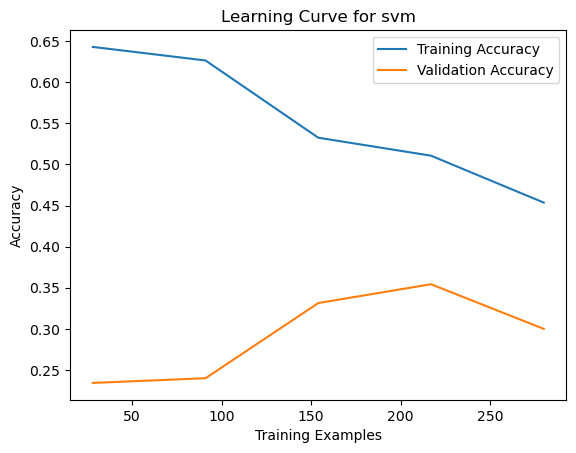

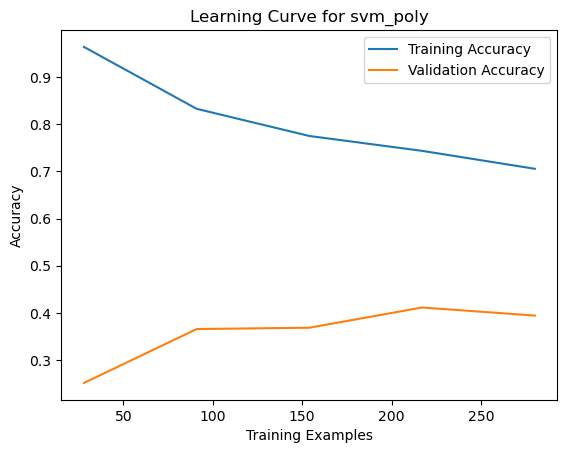

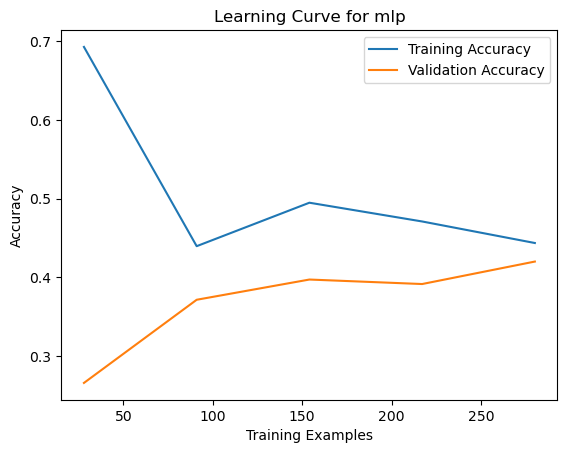

,name,accuracy,precision,f1_score
0,dtree,0.306818,0.286864,0.292830
1,svm,0.284091,0.290110,0.260455
2,svm_poly,0.375000,0.349867,0.359479
3,mlp,0.443182,0.349877,0.390230


In [7]:
from sklearn.model_selection import learning_curve

warnings.filterwarnings("ignore")

df_metrics = pd.DataFrame(columns=["name", "accuracy", "precision", "f1_score"])

for name, model in models:
	x_train, x_test, y_train, y_test = train_test_split(X_rescaled, y, test_size=0.2, random_state=42)

	model.fit(x_train, y_train)
	train_pred = model.predict(x_train)
	y_pred = model.predict(x_test)

	metrics = [name]
	metrics.append(accuracy_score(y_test, y_pred))
	metrics.append(precision_score(y_test, y_pred, average="weighted"))
	metrics.append(f1_score(y_test, y_pred, average="weighted"))

	df_metrics = pd.concat([df_metrics, pd.DataFrame([metrics], columns=df_metrics.columns)], ignore_index=True)

	# Plot learning curve to see overfitting and underfitting (from gpt)
	train_sizes, train_scores, val_scores = learning_curve(model, x_train, y_train, cv=5, scoring='accuracy')
	plt.figure()
	plt.plot(train_sizes, np.mean(train_scores, axis=1), label='Training Accuracy')
	plt.plot(train_sizes, np.mean(val_scores, axis=1), label='Validation Accuracy')
	plt.xlabel('Training Examples')
	plt.ylabel('Accuracy')
	plt.title(f'Learning Curve for {name}')
	plt.legend()
	plt.show()

display(df_metrics)

In [9]:
# To find list of accuracy and MSE values
# Without using the sklearn function cross_validate()
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold

n_splits=10
# step 1: randomize the dataset and create k equal size partitions
kf = KFold(n_splits=n_splits)

acc = 0
mse = 0

i = 0 #keep track of batch number
# step 5: iterate k times with a different testing subset
for train_indices, test_indices in kf.split(X_rescaled):

	# step 2-3: use k-1/k^th partition for the training/testing model
	start_train, stop_train = train_indices[0], train_indices[-1]+1
	start_test, stop_test = test_indices[0], test_indices[-1]+1
	
	# perform the training similar to Q1
	#this was based on the requirements in Q1
	mlp1 = MLPClassifier()
	mlp1.fit(X_rescaled[start_train:stop_train], y_onehot[start_train:stop_train])
	pred = mlp1.predict(X_rescaled[start_test:stop_test])
	
	# step 4: record the evaluating scores
	i+=1
	acc += accuracy_score(y_onehot[start_test:stop_test], pred)
	mse += mean_squared_error(y_onehot[start_test:stop_test], pred)
	
	print("\nAccuracy for batch ", i, " : ", accuracy_score(y_onehot[start_test:stop_test], pred))
	print("Mean Square Error for batch ", i, " : ", mean_squared_error(y_onehot[start_test:stop_test], pred))

# step 6: find the average and select the batch with highest evaluation scores
print('\nAverage Accuracy = ', acc / n_splits)
print('Average MSE = ', mse / n_splits)


Accuracy for batch  1  :  0.045454545454545456
Mean Square Error for batch  1  :  0.024431818181818176

Accuracy for batch  2  :  0.022727272727272728
Mean Square Error for batch  2  :  0.025568181818181816

Accuracy for batch  3  :  0.045454545454545456
Mean Square Error for batch  3  :  0.024431818181818176

Accuracy for batch  4  :  0.045454545454545456
Mean Square Error for batch  4  :  0.023863636363636365

Accuracy for batch  5  :  0.045454545454545456
Mean Square Error for batch  5  :  0.025

Accuracy for batch  6  :  0.06818181818181818
Mean Square Error for batch  6  :  0.023295454545454546

Accuracy for batch  7  :  0.045454545454545456
Mean Square Error for batch  7  :  0.024999999999999998

Accuracy for batch  8  :  0.022727272727272728
Mean Square Error for batch  8  :  0.025568181818181816

Accuracy for batch  9  :  0.023255813953488372
Mean Square Error for batch  9  :  0.02558139534883721

Accuracy for batch  10  :  0.046511627906976744
Mean Square Error for batch  10 

# Hyper Parameter

In [12]:
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.neural_network import MLPClassifier

# Define the hyperparameter grid
param_grid = {
	'hidden_layer_sizes': [(100,), (100, 25), (100, 50), (100,100)],
	'max_iter': [500, 800, 1000],
	'random_state': [42],
}

# Instantiate the MLPClassifier without specifying hyperparameters
mlp = MLPClassifier()

# For Grid Search
grid_search = GridSearchCV(estimator=mlp, param_grid=param_grid, cv=3)
grid_search.fit(X_rescaled, y_onehot)

# For Random Search
random_search = RandomizedSearchCV(estimator=mlp, param_distributions=param_grid, n_iter=10, cv=3)
random_search.fit(X_rescaled, y_onehot)

print("Grid Search")
print("Optimal Hyperparameters: ", grid_search.best_params_)
print("Optimal Accuracy: ", grid_search.best_score_)

best_model_grid = grid_search.best_estimator_
y_pred_grid = best_model_grid.predict(X_rescaled)
mse_grid = mean_squared_error(y_onehot, y_pred_grid)
print("Optimal MSE: ", mse_grid)

print("\nRandom Search")
print("Optimal Hyperparameters: ", random_search.best_params_)
print("Optimal Accuracy: ", random_search.best_score_)

best_model_random = random_search.best_estimator_
y_pred_random = best_model_random.predict(X_rescaled)
mse_random = mean_squared_error(y_onehot, y_pred_random)
print("Optimal MSE: ", mse_random)


Grid Search
Optimal Hyperparameters:  {'hidden_layer_sizes': (100, 100), 'max_iter': 1000, 'random_state': 42}
Optimal Accuracy:  0.23287671232876708
Optimal MSE:  0.020319634703196345

Random Search
Optimal Hyperparameters:  {'random_state': 42, 'max_iter': 800, 'hidden_layer_sizes': (100, 100)}
Optimal Accuracy:  0.2077625570776256
Optimal MSE:  0.021518264840182648
